In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
from tqdm import tqdm

In [16]:
from tqdm import tqdm
import torch.optim as optim

In [423]:
from sklearn.preprocessing import MinMaxScaler

# Defining Dataseat

In [17]:
from datasets import load_dataset

In [18]:
from datasets import disable_caching
disable_caching()

In [19]:
# good_files = []
# for i in range(1, 6):
#     new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
#     good_files.extend(new_files)

# test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
# print(good_files)
# print(test_files)

In [20]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [21]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [22]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [23]:
len(good_files), len(test_files)

(2200, 551)

In [24]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [25]:
train_labels = files_to_labels(good_files)

In [26]:
test_labels = files_to_labels(test_files)

In [27]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [28]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [29]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/31/78731.npy',
  '../../mtg-jamendo-dataset/all_data/71/1346171.npy'],
 ['../../mtg-jamendo-dataset/all_data/48/1223148.npy',
  '../../mtg-jamendo-dataset/all_data/92/1394892.npy'])

In [30]:
import time

In [31]:
# SEQ_LEN = 10000
# SEQ_LEN = 3000
SEQ_LEN = 1000
# SEQ_LEN = 5000

## Super Dumb Model

In [32]:
from torchvision import transforms

In [33]:
class FinetuningMusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
        self.padder = torch.zeros(96, seq_len)
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        effective_index = index % len(self.files)
        x = np.load(self.files[effective_index])
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        x = pad_sequence([x.T, self.padder.T], padding_value=-90, batch_first=True)[0].T
        old_x = x.unsqueeze(0)
        
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        
        x = self.transforms(compressed_x)
        
        item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[effective_index])}
        
        return item

In [34]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [35]:
noise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.Normalize((0.5542), (0.1604)),
    AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.Normalize((0.5542), (0.1604))
#     transforms.Resize((500, 500)),
])

In [36]:
longnoise_composed =  transforms.Compose([
    transforms.Normalize((0.5542), (0.1604)),
    AddGaussianNoise(0., 0.04)
])
longnonoise_composed =  transforms.Compose([
    transforms.Normalize((0.5542), (0.1604)),
])

In [37]:
# len(all_train)

In [38]:
# torch.cat(all_train).mean(), torch.cat(all_train).std()

In [39]:
# transforms.Normalize((0.5542), (0.1604))(new_r)

In [40]:
# (torch.clamp(r, min=-90, max=30) + 90) / 120

In [41]:
longft_train_dataset = FinetuningMusicDataset(train_np_files, train_labels, longnoise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
longft_test_dataset = FinetuningMusicDataset(test_np_files, test_labels, longnonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [42]:
longft_train_dataset[0]['input'].shape

torch.Size([1, 96, 1000])

In [43]:
ft_train_dataset = FinetuningMusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
ft_test_dataset = FinetuningMusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [44]:
batch_size=16

In [351]:
# ft_train_dl = DataLoader(
#     ft_train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

# ft_test_dl = DataLoader(
#     ft_test_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

ft_train_dl = DataLoader(
    longft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    longft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [447]:
c = nn.Conv2d(1, 16, kernel_size=3, stride=(1, 1), padding=0)

In [448]:
# start = torch.rand(1, 1, 500, 500)
# start = torch.rand(1, 1, 96, 3000)
start = torch.rand(1, 1, 96, 1000)

In [449]:
start.shape

torch.Size([1, 1, 96, 1000])

In [450]:
c(start).shape

torch.Size([1, 16, 94, 998])

In [357]:
c2 = nn.Conv2d(3, 1, kernel_size=5, stride=(1, 1), padding=0)

In [358]:
c2(c(start)).shape

torch.Size([1, 1, 83, 327])

In [359]:
avg = nn.AvgPool2d(kernel_size=5, stride=(1, 1), padding=0)

In [360]:
avg(c2(c(start))).shape

torch.Size([1, 1, 79, 323])

In [361]:
21 * 983

20643

In [362]:
96 * 3000

288000

In [363]:
class MultiHeadedOutput(nn.Module):
    def __init__(self):
        super(MultiHeadedOutput, self).__init__()
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                    nn.Linear(512, 512),
                    nn.LeakyReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(512, 1)
            ) for i in range(15)
#             ) for i in range(1)
        ])
        
    def forward(self, x: torch.Tensor):
        outputs = torch.concat([h(x) for h in self.heads], dim=1)
        return outputs

In [484]:
model = torch.nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=(1, 1), padding=0),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, stride=(1, 1), padding=0),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=(1, 1), padding=0),
    nn.LeakyReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(78720, 512),
    nn.LeakyReLU(),
    MultiHeadedOutput()
)

In [485]:
# model = torch.nn.Sequential(
#     nn.Conv2d(1, 3, kernel_size=10, stride=(1, 3), padding=0),
#     nn.LeakyReLU(),
#     nn.BatchNorm2d(3),
#     nn.Dropout2d(0.1),
#     nn.Conv2d(3, 1, kernel_size=10, stride=(1, 2), padding=0),
#     nn.LeakyReLU(),
#     nn.BatchNorm2d(1),
#     nn.Dropout2d(0.1),
#     nn.Conv2d(1, 1, kernel_size=10, stride=(1, 2), padding=0),
#     nn.LeakyReLU(),
#     nn.BatchNorm2d(1),
#     nn.AvgPool2d(kernel_size=5, stride=(1, 1), padding=0),
#     nn.Dropout2d(0.1),
    
#     nn.Flatten(),
#     nn.Linear(4680, 1024),
# #     nn.Linear(50176, 512),
#     nn.LeakyReLU(),
#     nn.Dropout(0.1),
#     nn.Linear(1024, 512),
#     nn.LeakyReLU(),
#     nn.Dropout(0.1),
#     MultiHeadedOutput()
# )

# # model = torch.nn.Sequential(
# #     nn.Flatten(),
# #     nn.Linear(50176, 1024),
# #     nn.Dropout(0.1),
# # #     nn.Linear(54 * 164, 1024),
# #     nn.LeakyReLU(),
# # #     nn.Dropout(0.1),
# #     nn.Linear(1024, 512),
# #     nn.LeakyReLU(),
# #     nn.Dropout(0.1)
# # )

In [486]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [487]:
# model = m = MyModel()

In [488]:
model = model.to(device)

In [489]:
# pos_weight = 1 / (torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels))
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))

In [490]:
pos_weight

tensor([22.0400, 22.0400, 16.2059, 14.8919, 16.6970, 16.6970, 15.7429, 15.3056,
        14.8919, 11.2449, 14.5000, 11.7234,  8.8871, 12.8140, 11.7234],
       dtype=torch.float64)

In [491]:
model(start.to(device))

tensor([[ 0.0576,  0.0120,  0.0163, -0.0054,  0.0072, -0.0123,  0.0001,  0.0167,
         -0.0475,  0.0119,  0.0097, -0.0060,  0.0410,  0.0049,  0.0443]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [492]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0.05, betas=(0.9, 0.95))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05, betas=(0.9, 0.95))
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device), reduction="sum")

In [493]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        total_loss += criterion(outputs, labels.float())
    return total_loss.item()

In [494]:
model.train()
ft_train_losses = []
ft_test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
#     for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
#     for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
#         outputs = torch.concat([h(outputs) for h in heads], dim=1)  
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
        
    with torch.no_grad():
        train_total_loss = total_loss
        test_loss = get_total_loss(model, ft_test_dl)
        ft_train_losses.append(train_total_loss)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {train_total_loss}; Test Loss: {test_loss}")

_ = model.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:03<00:00, 10.87it/s]


Epoch: 0; Loss: 220103.48268406597; Test Loss: 11151.76171875


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:02<00:00, 10.95it/s]


Epoch: 1; Loss: 219142.80058147482; Test Loss: 11218.0205078125


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:02<00:00, 11.05it/s]


Epoch: 2; Loss: 217685.9232781526; Test Loss: 11457.7568359375


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:03<00:00, 10.91it/s]


Epoch: 3; Loss: 216309.40068170722; Test Loss: 11344.892578125


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:03<00:00, 10.85it/s]


Epoch: 4; Loss: 214812.13810857738; Test Loss: 11448.1064453125


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:03<00:00, 10.87it/s]


Epoch: 5; Loss: 212123.14825779002; Test Loss: 11807.369140625


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:04<00:00, 10.73it/s]


Epoch: 6; Loss: 210830.300028444; Test Loss: 11888.376953125


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:04<00:00, 10.70it/s]


Epoch: 7; Loss: 208858.39593909547; Test Loss: 11843.19140625


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:06<00:00, 10.38it/s]


Epoch: 8; Loss: 207445.10960722927; Test Loss: 11802.40625


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:04<00:00, 10.65it/s]


Epoch: 9; Loss: 205364.8991895425; Test Loss: 14689.9111328125


Text(0.5, 1.0, 'Dumb so stupid Finetuning Train/Test Loss')

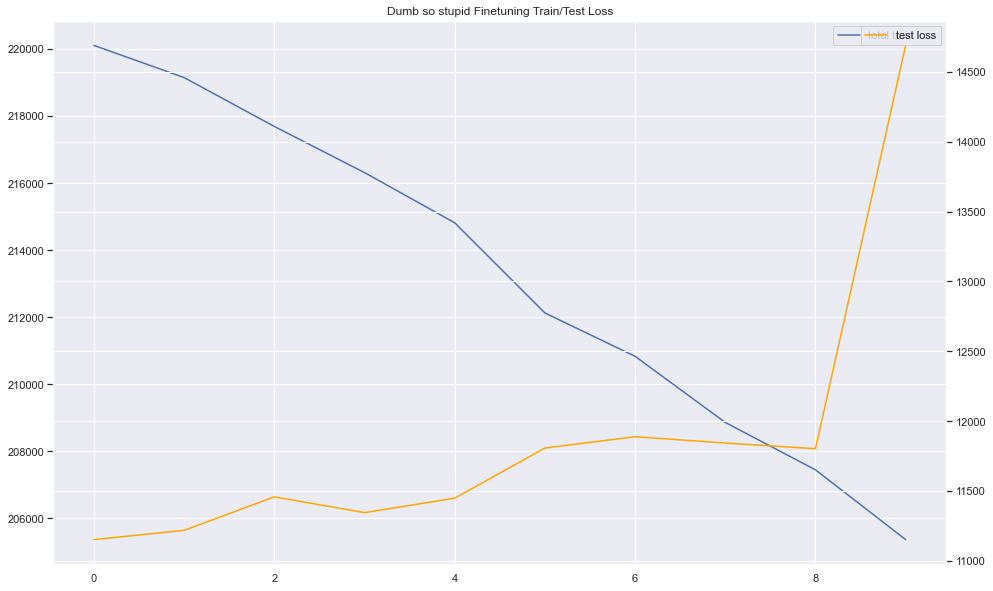

In [495]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=1)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=1)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("Dumb so stupid Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [496]:
# ft_trainnosample_dataset = FinetuningMusicDataset(train_np_files, train_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=1)

In [497]:
# ft_train_eval_dl = DataLoader(
#     ft_trainnosample_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

In [498]:
import torch.nn.functional as F

In [499]:
inputs.shape

torch.Size([8, 1, 96, 1000])

In [507]:
model.eval()
# for h in heads:
#     h.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
#     for batch_idx, data in enumerate(ft_test_dl):
    for batch_idx, data in enumerate(ft_train_dl):
#     for batch_idx, data in enumerate(longft_test_dataset):
#     for batch_idx, data in enumerate(ft_train_eval_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
#         outputs = torch.concat([h(outputs) for h in heads], dim=1)
        outputs = torch.sigmoid(outputs)
        
        combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

0.5732666666666667
94589 out of 165000
Performance on positive labels
0.6559307359307359
7576 out of 11550.0
WHAT IF WE JUST PREDICTED ZERO
0.93
153450 out of 165000


In [508]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

(torch.Size([11000, 15]), torch.Size([11000, 15]))

In [509]:
len(ft_test_dataset)

551

In [510]:
from sklearn import metrics

In [511]:
all_preds

tensor([[0.0313, 0.0918, 0.3369,  ..., 0.0310, 0.2721, 0.3678],
        [0.7087, 0.6196, 0.4376,  ..., 0.3985, 0.6437, 0.5471],
        [0.5242, 0.1320, 0.3732,  ..., 0.3582, 0.6567, 0.6663],
        ...,
        [0.6152, 0.2744, 0.3949,  ..., 0.4431, 0.5532, 0.5270],
        [0.0304, 0.2965, 0.0584,  ..., 0.3331, 0.3612, 0.3082],
        [0.4198, 0.4499, 0.3191,  ..., 0.4451, 0.5631, 0.5464]],
       device='cuda:0')

In [512]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.7553868380109515
Head: 1; AUC: 0.7144591673162051
Head: 2; AUC: 0.6805911057692309
Head: 3; AUC: 0.6469893675874964
Head: 4; AUC: 0.7085325879518072
Head: 5; AUC: 0.7255519475955524
Head: 6; AUC: 0.6543126698562616
Head: 7; AUC: 0.716203647454097
Head: 8; AUC: 0.5894502493750815
Head: 9; AUC: 0.6820330394364847
Head: 10; AUC: 0.6641418553217974
Head: 11; AUC: 0.6047781840357137
Head: 12; AUC: 0.6512410840904127
Head: 13; AUC: 0.6635438134707289
Head: 14; AUC: 0.6507766044554875


In [513]:
sum(aucs) / len(aucs)

0.673866144115154

In [239]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    # You can use pre-existing models but change layers to recieve full credit.
    def __init__(self):
        super(MyModel, self).__init__()
        #############################################################################
        # TODO: Initialize the network weights                                      #
        #############################################################################
        
        # Try a resnet like thing
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = (1, 2), padding = 0),
                        # nn.Conv2d(3, 128, kernel_size = 3, stride = 2, padding = 1),
                        # nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64, 64, kernel_size = 3, stride = (1, 2), padding = 0),
                        # nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1),
                        # nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1),
                        # nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        # nn.ReLU(),
                        # nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
                        nn.MaxPool2d(kernel_size = 3, stride = (1, 2), padding = 0),
                    )

        self.extraconv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
        )

        self.conv2 = nn.Sequential(
                        nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),

                        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
                    )

        self.after_res1 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
        )
        
        self.extraconv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
        )
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
                    )
        
        # Do Global? AvgPool since this is the last layer
        self.after_res2 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=5, stride=3, padding=1)
        )

        self.linear1 = nn.Sequential(
#             nn.Linear(12800, 512),
            nn.Linear(157440, 512),
            nn.ReLU(),
        )
        self.linear_out = MultiHeadedOutput()
#         self.linear2 = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#         )
#         self.linear3 = nn.Linear(256, 15)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

    def forward(self, x):
        outs = None
        #############################################################################
        # TODO: Implement forward pass of the network                               #
        #############################################################################
        def flatten(x):
            return torch.flatten(x, 1)

        outs = x
        outs = self.conv1(outs)
        res = self.extraconv1(outs)
        outs = self.conv2(outs)
        outs = outs + res
        
        outs = self.after_res1(outs)
        
        res2 = self.extraconv2(outs)

        outs = self.conv3(outs)

        outs = outs + res2

        outs = self.after_res2(outs)

        outs = flatten(outs)
        outs = self.linear1(outs)
#         outs = self.linear2(outs)
#         outs = self.linear3(outs)
        outs = self.linear_out(outs)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return outs

In [240]:
m = MyModel()

In [242]:
m(start).shape

torch.Size([1, 15])